# Exploratory Data Analysis

#### Install Dependencies

In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#/content/drive/MyDrive/tokenized_dataset

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

#### Confirm CUDA

In [ ]:
import torch
torch.cuda.is_available()

True

#### Load Dataset

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

!kaggle datasets download -d fabiochiusano/medium-articles

!mkdir train
!unzip medium-articles.zip -d train

from datasets import load_dataset
original_dataset = load_dataset("csv", data_files="train/medium_articles.csv")



Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                            title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset             Customer Shopping Trends Dataset                   146KB  2023-10-05 06:45:37          13905        301  1.0              
asaniczka/top-spotify-songs-in-73-countries-daily-updated      Top Spotify Songs in 73 Countries (Daily Updated)    4MB  2023-10-30 23:37:27           1448         44  1.0              
nelgiriyewithana/billionaires-statistics-dataset               Billionaires Statistics Dataset (2023)             139KB  2023-09-29 13:39:28           7363   

In [ ]:
original_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
        num_rows: 192368
    })
})

In [ ]:
df = pd.DataFrame.from_dict(original_dataset['train'])
df

,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology..."
...,...,...,...,...,...,...
192363,Why do you need a cleaning service?,What could be more important than having a tid...,https://medium.com/@ozneedcleaningau/why-do-yo...,[],2021-11-16 08:17:08.950000+00:00,"['Cleaning', 'Cleaning Services', 'Cleaning Co..."
192364,Daily cleaning and maintenance of bedding,Daily cleaning and maintenance of bedding\n\nW...,https://medium.com/@a198blwt/daily-cleaning-an...,[],2021-11-16 05:27:05.359000+00:00,"['Bedding', 'Cleaning', 'Maintain']"
192365,Beneficial Advice on Bond Cleaning!,The most important chore at the end is bond cl...,https://medium.com/@princegohil/beneficial-adv...,['Prince Shrawan'],2021-11-26 08:20:27.660000+00:00,"['Cleaning', 'End Of Lease Cleaning', 'Cleaners']"
192366,How I Learned Romanian in 37 Easy Steps,How I Learned Romanian in 37 Easy Steps\n\nHey...,https://medium.com/@lifeinromania/how-i-learne...,['Sam Ursu'],2017-11-27 08:09:19.025000+00:00,"['Romania', 'Language Learning', 'Storyofmylife']"


In [ ]:
df.dropna(inplace=True) #Drop any row with a null value
df['text'] = df['text'].str.strip() # Strip White spaces
df['title'] = df['title'].str.strip() # Strip White spaces from title
df.drop_duplicates(inplace=True)

In [ ]:
#Converting Tags from string to List
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


Average title length (words): 7.77
Min title length (words): 1
Max title length (words): 44


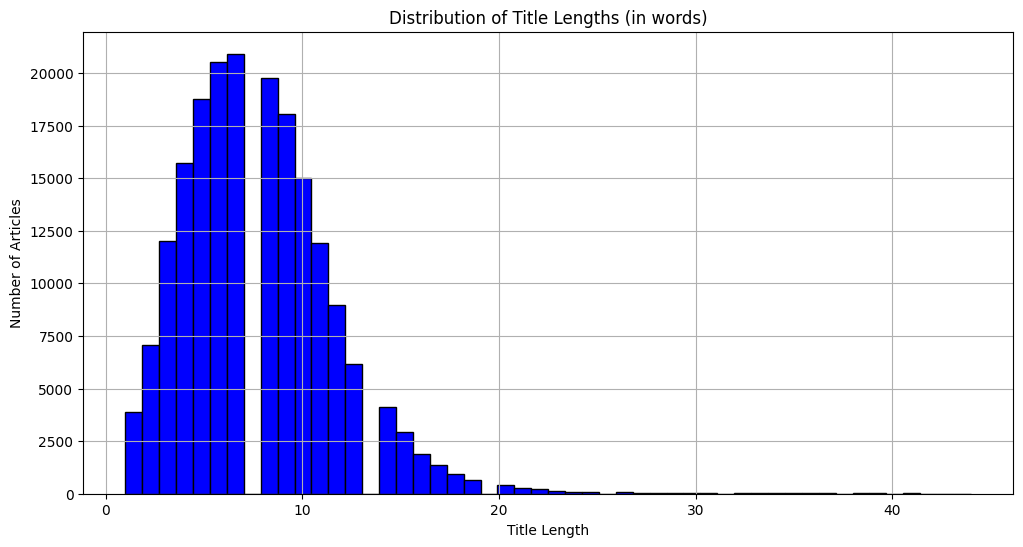

In [ ]:
# 1. Text Analysis

df['title_word_length'] = df['title'].apply(lambda x: len(x.split()))
print(f"Average title length (words): {df['title_word_length'].mean():.2f}")
print(f"Min title length (words): {df['title_word_length'].min()}")
print(f"Max title length (words): {df['title_word_length'].max()}")

plt.figure(figsize=(12, 6))
plt.hist(df['title_word_length'], bins=50, color='blue', edgecolor='black')
plt.title("Distribution of Title Lengths (in words)")
plt.xlabel("Title Length")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.show()


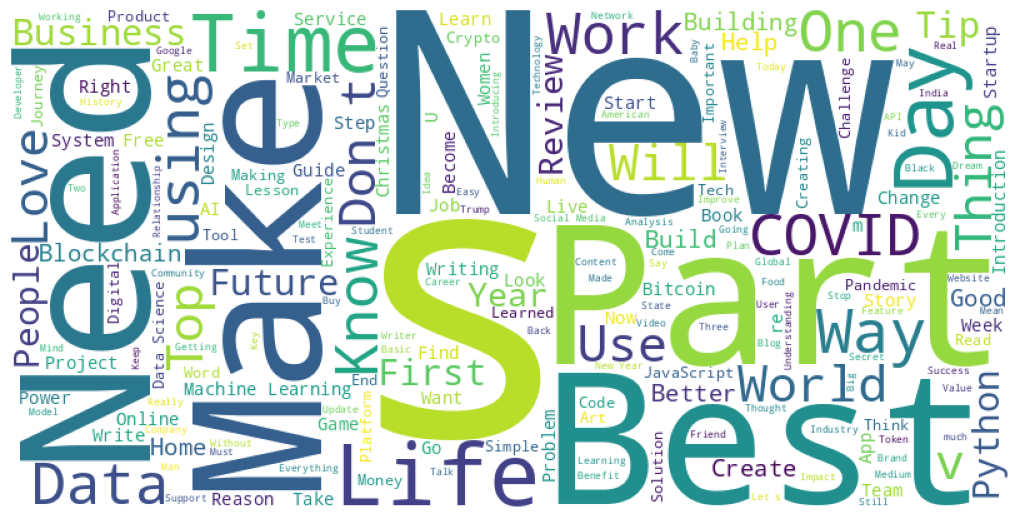

In [ ]:
from wordcloud import WordCloud

# Create a single string with all titles
all_titles = ' '.join(df['title'].dropna())
# Generate the word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white'
).generate(all_titles)

# Plotting the WordCloud image
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

----- Text Analysis -----
Average text length (words): 845.78
Min text length (words): 3
Max text length (words): 18952


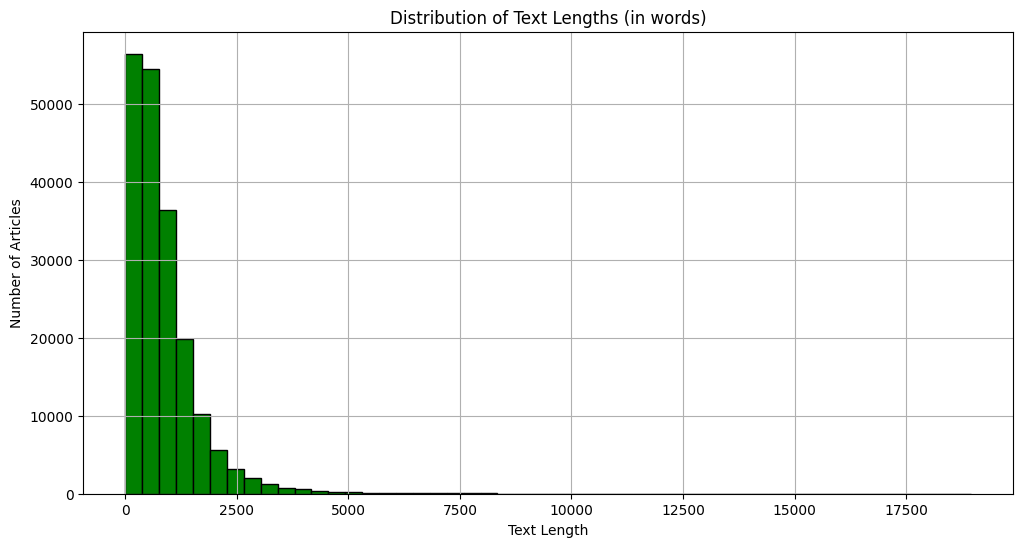

In [ ]:
# 2. Text Analysis
df['text_word_length'] = df['text'].apply(lambda x: len(x.split()))

print("----- Text Analysis -----")
print(f"Average text length (words): {df['text_word_length'].mean():.2f}")
print(f"Min text length (words): {df['text_word_length'].min()}")
print(f"Max text length (words): {df['text_word_length'].max()}")

plt.figure(figsize=(12, 6))
plt.hist(df['text_word_length'], bins=50, color='green', edgecolor='black')
plt.title("Distribution of Text Lengths (in words)")
plt.xlabel("Text Length")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.show()


----- Tags Analysis -----
Average number of tags per article: 4.58
Min number of tags: 1
Max number of tags: 5


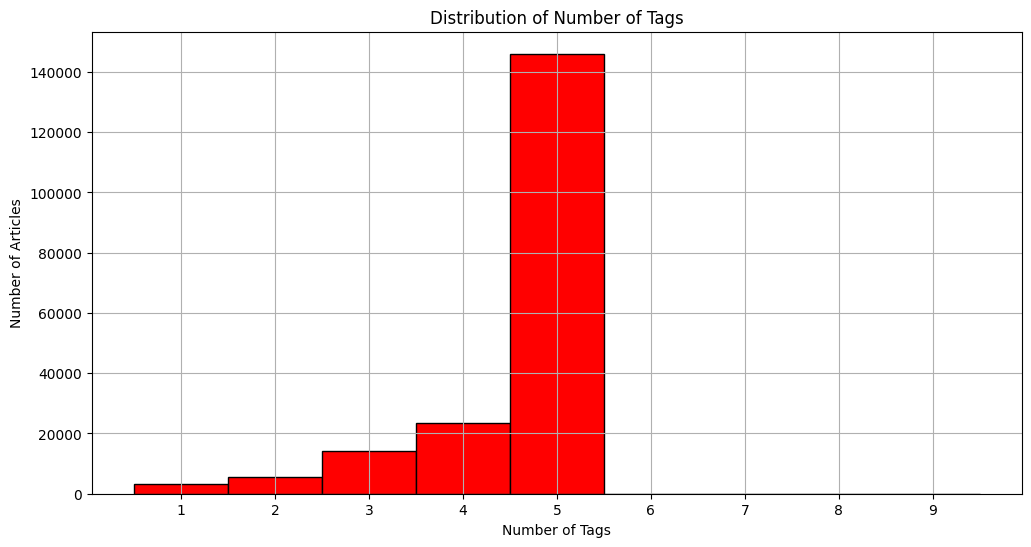

In [ ]:
# 3. Tags Analysis

df['num_tags'] = df['tags'].apply(len)

print("----- Tags Analysis -----")
print(f"Average number of tags per article: {df['num_tags'].mean():.2f}")
print(f"Min number of tags: {df['num_tags'].min()}")
print(f"Max number of tags: {df['num_tags'].max()}")

plt.figure(figsize=(12, 6))
plt.hist(df['num_tags'], bins=range(1, 11), align='left', color='red', edgecolor='black')
plt.title("Distribution of Number of Tags")
plt.xlabel("Number of Tags")
plt.ylabel("Number of Articles")
plt.xticks(range(1, 10))
plt.grid(True)
plt.show()

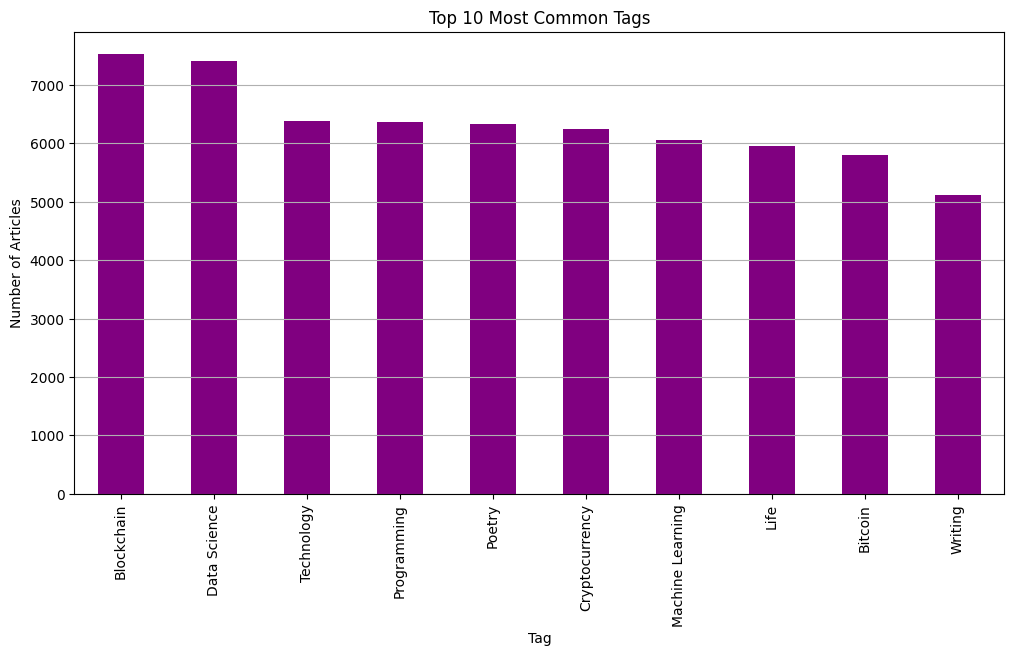

In [ ]:
# Most common tags
all_tags = [tag for sublist in df['tags'] for tag in sublist]
tag_series = pd.Series(all_tags)
top_tags = tag_series.value_counts().head(10)

plt.figure(figsize=(12, 6))
top_tags.plot(kind='bar', color='purple')
plt.title("Top 10 Most Common Tags")
plt.xlabel("Tag")
plt.ylabel("Number of Articles")
plt.grid(axis='y')
plt.show()

#### Tag Co occurence

In [ ]:
from itertools import combinations
from collections import Counter

# Count pairs
tag_pairs = Counter()

for tags in df['tags']:
    # Get all combinations of pairs from tags
    for combo in combinations(tags, 2):
        # Sort the pair so that ('Tag1', 'Tag2') and ('Tag2', 'Tag1') are counted as the same
        tag_pairs[tuple(sorted(combo))] += 1

# Most common pairs
common_pairs = tag_pairs.most_common(10)
print(common_pairs)


[(('Blockchain', 'Cryptocurrency'), 3413), (('Bitcoin', 'Cryptocurrency'), 3380), (('Data Science', 'Machine Learning'), 3057), (('Bitcoin', 'Blockchain'), 2906), (('Artificial Intelligence', 'Machine Learning'), 1729), (('Blockchain', 'Ethereum'), 1710), (('Programming', 'Software Development'), 1648), (('Data Science', 'Python'), 1585), (('JavaScript', 'Programming'), 1430), (('Life', 'Life Lessons'), 1359)]


#### Anamoly Detection

In [ ]:
short_threshold = 10  # adjust based on your requirements
short_articles = df[df['text_word_length'] < short_threshold]
print(f"Number of extremely short articles: {len(short_articles)}")

Number of extremely short articles: 1317


In [ ]:
short_articles

,title,text,url,authors,timestamp,tags,title_word_length,text_word_length,num_tags,word_count
626,[原來根本搞錯問題] 從模式選擇談壞味道識別,Kuma老師的軟體工程教室\n\nWelcome to the Kingdom of Sof...,https://medium.com/kuma%E8%80%81%E5%B8%AB%E7%9...,['Yu-Song Syu'],2020-10-26 14:09:42.747000+00:00,"[Design Patterns, Coding, Development, Code Sm...",2,8,5,8
1339,[DeNA TechCon 2020 ライブ配信] DeNA データプラットフォームにおける...,in In Fitness And In Health,https://medium.com/dena-analytics-blog/dena-te...,[],2020-03-26 05:32:13.382000+00:00,"[Bigquery, Analytics, Kubernetes, Data Enginee...",6,6,5,6
1445,ARLECHINO se intoarce la origini!,in In Fitness And In Health,https://medium.com/platforma-dezarticulat/arle...,[],2018-02-05 21:10:45.677000+00:00,"[Humor, Journalism, Trap, Arlechino, Music]",5,6,5,6
1576,Semicolon e detalhes do dia a dia,in In Fitness And In Health,https://medium.com/publicitariossc/semicolon-e...,['Thiago Acioli'],2017-05-09 16:12:22.412000+00:00,"[Sem Categoria, Curiosidades, Facebook, Fotogr...",7,6,5,6
2730,當創新創業從傳奇故事變成科學實驗,in In Fitness And In Health,https://medium.com/yiyi-network/startup-as-a-s...,[],2020-04-02 16:32:58.770000+00:00,"[Steve Blank, Startup, Business Model Canvas, ...",1,6,5,6
...,...,...,...,...,...,...,...,...,...,...
134629,Naufragio Por la Arena,in Change Your Mind Change Your Life,https://medium.com/@sopalucac/naufragio-por-la...,['Tangled Wonders'],2020-09-15 14:44:51.507000+00:00,"[Poema, Español, Ficción, Filosofía, Literatura]",4,7,5,7
134631,40 años de Ashes to Ashes,in Change Your Mind Change Your Life,https://medium.com/@marcopatino/40-a%C3%B1os-d...,['Marco Patiño'],2020-09-12 21:57:29.076000+00:00,"[Spanish, David Bowie, Español, Ashes To Ashes...",6,7,5,7
134651,Esfumarse,in Change Your Mind Change Your Life,https://medium.com/@elescritorfant/esfumarse-b...,['Pablo Poveda'],2020-08-25 06:07:29.335000+00:00,"[Spanish, Escritura, Español, Vida, Medium En ...",1,7,5,7
134656,Aprende Desarrollo Web | HTML basico,in Change Your Mind Change Your Life,https://medium.com/@andresnew00/aprende-desarr...,['Andres Inciarte'],2020-08-13 19:19:36.444000+00:00,"[Aprender, Español, Diseño Web, Aprende, HTML]",6,7,5,7


In [ ]:
# Calculate IQR
Q1 = df['text_word_length'].quantile(0.25)
Q3 = df['text_word_length'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = max(0, Q1 - 1.5 * IQR)  # Ensure lower bound is non-negative
upper_bound = Q3 + 1.5 * IQR
print("Upper Bound:",upper_bound)
long_articles = df[df['text_word_length'] > upper_bound]
print(f"Number of excessively long articles: {len(long_articles)}")


Upper Bound: 2254.0
Number of excessively long articles: 9450


In [ ]:
long_articles

,title,text,url,authors,timestamp,tags,title_word_length,text_word_length,num_tags,word_count
24,"Don’t Be a Writer, Be an Entrepreneur Who Writes","Don’t Be a Writer, Be an Entrepreneur Who Writ...",https://medium.com/swlh/dont-be-a-writer-be-an...,['David Mercer'],2020-08-28 15:29:50.267000+00:00,"[Entrepreneurship, Writing, Startup, Marketing...",9,2424,5,2424
84,A Goodbye to Golden Muzzles: Internal Dissent ...,"In 2019, former CIA agent Yael Eisenstat was s...",https://medium.com/swlh/a-goodbye-to-golden-mu...,['Raman Frey'],2020-12-11 13:55:38.098000+00:00,"[Facebook, Conflict, Business, Trust, Startup]",13,2318,5,2318
105,Google Objectron — A giant leap for the 3D obj...,bjecrPhoto by Tamara Gak on Unsplash\n\nGoogle...,https://towardsdatascience.com/google-objectro...,['Jair Ribeiro'],2020-11-23 17:48:03.183000+00:00,"[Object Detection, Google, AI, Computer Vision...",11,2397,5,2397
121,What Cycling Across Canada Taught Me About Sta...,I biked across Canada in the summer of 2017.\n...,https://medium.com/the-ascent/what-cycling-acr...,['Ramsay Lewis'],2020-09-06 20:01:01.327000+00:00,"[Life Lessons, Inspiration, Entrepreneurship, ...",11,2542,5,2542
131,Who Rules the Cloud Service: AWS or Azure?,Amazon Web Service (AWS)\n\nAWS is owned by Am...,https://medium.com/datadriveninvestor/who-rule...,['Vishnu Aravindhan'],2020-12-29 17:38:33.158000+00:00,"[Microsoft, Amazon, Cloud Computing, Software ...",8,2303,5,2303
...,...,...,...,...,...,...,...,...,...,...
192315,When in Rome… Literally,When in Rome… Literally\n\n*This is part 2 in ...,https://medium.com/design-your-dream-life/when...,['Kerri Richardson'],2016-08-22 22:39:37.515000+00:00,"[Blog, Wine, Couchsurfing, Europe, Hotel]",4,3527,5,3527
192331,(Live — Streaming) : 2021 Soul Train Music Awards,(Live — Streaming) : 2021 Soul Train Music Awa...,https://medium.com/@2021_Soul-Train-Music-Awar...,"['Soul Train Music Awards', 'Full Show']",2021-11-28 11:51:56.080000+00:00,"[Music, Awards, Festivals, Technology, Bussiness]",9,2849,5,2849
192333,[Live Stream] 2021 Soul Train Music Awards | F...,[Live Stream] 2021 Soul Train Music Awards | F...,https://medium.com/@2021_Soul-Train-Music-Awar...,"['Soul Train Music Awards', 'Full Show']",2021-11-28 11:52:45.133000+00:00,"[Technology, Bussiness, Music, Festivals, Awards]",12,2849,5,2849
192341,Down to Earth traditional celebration of Diwal...,The midterm vacations for the schools in Goa i...,https://medium.com/@larapereiranaik/down-to-ea...,['Lara Pereira Naik'],2022-01-24 05:58:28.472000+00:00,"[Goa, Diwali, Festivals]",10,3236,3,3236


### END OF THE NOTEBOOK